# XOR回路をNEATで学習

In [1]:
import os

from problems.XOR.load_problem import load_XOR

In [2]:
problem = "xor"

inputs, outputs = load_XOR(problem)

print("Loaded {} dataset with {} inputs and {} outputs".format(problem, len(inputs[0]), len(outputs[0])))
print(inputs)
print(outputs)

Loaded xor dataset with 2 inputs and 1 outputs
[[0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 1.]]
[[0.]
 [1.]
 [1.]
 [0.]]


In [3]:
# Configの読み込み
from neat.config import Config
from neat.genome import DefaultGenome
from neat.reproduction import DefaultReproduction
from neat.stagnation import DefaultStagnation
from neat.species import DefaultSpeciesSet
from neat.stagnation import DefaultStagnation

conf = Config(DefaultGenome, DefaultReproduction, DefaultSpeciesSet, DefaultStagnation, f"./config/{problem}_config.cfg")

In [4]:
# 1. 初期集団の生成
from neat.population import Population

p = Population(conf)

# 2. 評価
from neat.nn import FeedForwardNetwork

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = FeedForwardNetwork.create(genome, config)
        genome.fitness = 4.0
        for xi, xo in zip(inputs, outputs):
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2

# 3. 実行
best_genome = p.run(eval_genomes)

In [5]:
# 4. 結果
print(best_genome)

Key: 55707
Fitness: 4.0
Nodes:
	0 DefaultNodeGene(key=0, bias=-3.620294860087953, response=-0.24211893626743217, activation=sigmoid, aggregation=sum)
	184 DefaultNodeGene(key=184, bias=-2.860219387101019, response=1.063335128875159, activation=sigmoid, aggregation=sum)
	581 DefaultNodeGene(key=581, bias=-2.7010552203284, response=2.0175607894910033, activation=sigmoid, aggregation=sum)
	9938 DefaultNodeGene(key=9938, bias=0.8880695795964157, response=-0.2514681661693035, activation=sigmoid, aggregation=sum)
	10129 DefaultNodeGene(key=10129, bias=1.8661988709037283, response=0.5190164098617166, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-2, 184), weight=5.199173898231211, enabled=True)
	DefaultConnectionGene(key=(-2, 581), weight=-2.959325700982459, enabled=True)
	DefaultConnectionGene(key=(-2, 9938), weight=2.3955152239665654, enabled=False)
	DefaultConnectionGene(key=(-2, 10129), weight=-0.08442675763076998, enabled=True)
	DefaultConnectionGene(key=(

In [10]:
# 5. ネットワークの可視化
import graphviz
import warnings

def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    # If requested, use a copy of the genome which omits all components that won't affect the output.
    if prune_unused:
        genome = genome.get_pruned_copy(config.genome_config)

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    used_nodes = set(genome.nodes.keys())
    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            # if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot

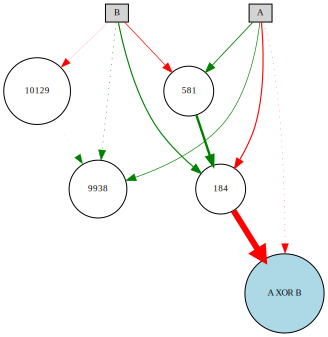

In [14]:
draw_net(conf, best_genome, node_names={-1: 'A', -2: 'B', 0: 'A XOR B'})